## Importing Modules

In [1]:
#%matplotlib notebook
from tqdm import tqdm
%matplotlib inline
#Module to handle regular expressions
import re
#manage files
import os
#Library for emoji
import emoji
#Import pandas and numpy to handle data
import pandas as pd
import numpy as np

#import libraries for accessing the database
import psycopg2
from sqlalchemy import create_engine
from postgres_credentials import *

#import libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image

#Import nltk to check english lexicon
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import (
    wordnet,
    stopwords
)

#import libraries for tokenization and ML
import json;
import keras;
import keras.preprocessing.text as kpt;
#from keras.preprocessing.text import Tokenizer;

import sklearn
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfVectorizer
)
from sklearn.model_selection import train_test_split

#Import all libraries for creating a deep neural network
#Sequential is the standard type of neural network with stackable layers
from keras.models import Sequential;
#Dense: Standard layers with every node connected, dropout: avoids overfitting
from keras.layers import Dense, Dropout, Activation;

#To anotate database
from pycorenlp import StanfordCoreNLP

Using TensorFlow backend.


In [2]:
#Querying the database
def query_database(tabletweets):
    engine = create_engine("postgresql+psycopg2://%s:%s@%s:%d/%s" %(usertwitter, passwordtwitter, hosttwitter, porttwitter, dbnametwitter))
    table = pd.read_sql_query('select * from %s' %tabletweets,con=engine, index_col='id')
    return table

In [3]:
def anotate_dataframe(row):
    nlp = StanfordCoreNLP('http://localhost:9000')
    a = []
    res = nlp.annotate(row,
                           properties={
                               'annotators': 'sentiment',
                               'outputFormat': 'json',
                               'timeout': 10000,
                           })
    
    for s in res["sentences"]:
        a = s["sentiment"]
    return a

## Preprocessing the text

In [4]:
#preprocess text in tweets by removing links, @UserNames, blank spaces, etc.
def preprocessing_text(table):
    #put everythin in lowercase
    table['tweet'] = table['tweet'].str.lower()
    #Replace rt indicating that was a retweet
    table['tweet'] = table['tweet'].str.replace('rt', '')
    #Replace occurences of mentioning @UserNames
    table['tweet'] = table['tweet'].replace(r'@\w+', '', regex=True)
    #Replace links contained in the tweet
    table['tweet'] = table['tweet'].replace(r'http\S+', '', regex=True)
    table['tweet'] = table['tweet'].replace(r'www.[^ ]+', '', regex=True)
    #remove numbers
    table['tweet'] = table['tweet'].replace(r'[0-9]+', '', regex=True)
    #replace special characters and puntuation marks
    table['tweet'] = table['tweet'].replace(r'[!"#$%&()*+,-./:;<=>?@[\]^_`{|}~]', '', regex=True)
    return table    

In [5]:
#Replace elongated words by identifying those repeated characters and then remove them and compare the new word with the english lexicon
def in_dict(word):
    if wordnet.synsets(word):
        #if the word is in the dictionary, we'll return True
        return True

def replace_elongated_word(word):
    regex = r'(\w*)(\w+)\2(\w*)'
    repl = r'\1\2\3'    
    if in_dict(word):
        return word
    new_word = re.sub(regex, repl, word)
    if new_word != word:
        return replace_elongated_word(new_word)
    else:
        return new_word

def detect_elongated_words(row):
    regexrep = r'(\w*)(\w+)(\2)(\w*)'
    words = [''.join(i) for i in re.findall(regexrep, row)]
    for word in words:
        if not in_dict(word):
            row = re.sub(word, replace_elongated_word(word), row)
    return row 

In [6]:
def stop_words(table):
    #We need to remove the stop words
    stop_words_list = stopwords.words('english')
    table['tweet'] = table['tweet'].str.lower()
    table['tweet'] = table['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words_list)]))
    return table

In [7]:
def replace_antonyms(word):
    #We get all the lemma for the word
    for syn in wordnet.synsets(word): 
        for lemma in syn.lemmas(): 
            #if the lemma is an antonyms of the word
            if lemma.antonyms(): 
                #we return the antonym
                return lemma.antonyms()[0].name()
    return word
            
def handling_negation(row):
    #Tokenize the row
    words = word_tokenize(row)
    speach_tags = ['JJ', 'JJR', 'JJS', 'NN', 'VB', 'VBD', 'VBG', 'VBN', 'VBP']
    #We obtain the type of words that we have in the text, we use the pos_tag function
    tags = nltk.pos_tag(words)
    #Now we ask if we found a negation in the words
    tags_2 = ''
    if "n't" in words and "not" in words:
        tags_2 = tags[min(words.index("n't"), words.index("not")):]
        words_2 = words[min(words.index("n't"), words.index("not")):]
        words = words[:(min(words.index("n't"), words.index("not")))+1]
    elif "n't" in words:
        tags_2 = tags[words.index("n't"):]
        words_2 = words[words.index("n't"):] 
        words = words[:words.index("n't")+1]
    elif "not" in words:
        tags_2 = tags[words.index("not"):]
        words_2 = words[words.index("not"):]
        words = words[:words.index("not")+1] 
        
    for index, word_tag in enumerate(tags_2):
        if word_tag[1] in speach_tags:
            words = words+[replace_antonyms(word_tag[0])]+words_2[index+2:]
            break
            
    return ' '.join(words)    

In [8]:
def cleaning_table(table):
    #This function will process all the required cleaning for the text in our tweets
    table = preprocessing_text(table)
    table['tweet'] = table['tweet'].apply(lambda x: detect_elongated_words(x))
    table['tweet'] = table['tweet'].apply(lambda x: handling_negation(x))
    table = stop_words(table)
    return table

## Data Visualization

In [9]:
#Vectorization for Data Visualization
def vectorization(table):
    #CountVectorizer will convert a collection of text documents to a matrix of token counts
    #Produces a sparse representation of the counts 
    #Initialize
    vector = CountVectorizer()
    #We fit and transform the vector created
    frequency_matrix = vector.fit_transform(table.tweet)
    #Sum all the frequencies for each word
    sum_frequencies = np.sum(frequency_matrix, axis=0)
    #Now we use squeeze to remove single-dimensional entries from the shape of an array that we got from applying np.asarray to
    #the sum of frequencies.
    frequency = np.squeeze(np.asarray(sum_frequencies))
    #Now we get into a dataframe all the frequencies and the words that they correspond to
    frequency_df = pd.DataFrame([frequency], columns=vector.get_feature_names()).transpose()
    return frequency_df

In [10]:
def word_cloud(tweets):
    
    #We get the directory that we are working on
    file = os.getcwd()
    #We read the mask image into a numpy array
    avengers_mask = np.array(Image.open(os.path.join(file, "avengers.png")))
    #Now we store the tweets into a series to be able to process 
    #tweets_list = pd.Series([t for t in tweet_table.tweet]).str.cat(sep=' ')  
    #We generate the wordcloud using the series created and the mask 
    word_cloud = WordCloud(width=2000, height=1000, max_font_size=200, background_color="black", max_words=2000, mask=avengers_mask, contour_width=1, 
                           contour_color='steelblue', colormap='nipy_spectral', stopwords=['avengers'])
    word_cloud.generate(tweets)
    
    #wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(tweets_list)
    
    #Now we plot both figures, the wordcloud and the mask
    #plt.figure(figsize=(15,15))
    plt.figure(figsize=(10,10))
    plt.imshow(word_cloud, interpolation="hermite")
    plt.axis("off")
    #plt.imshow(avengers_mask, cmap=plt.cm.gray, interpolation="bilinear")
    #plt.axis("off")    
    plt.show()  

In [11]:
def graph(table, sent):
    word_frequency = vectorization(table).sort_values(0, ascending = False)
    labels = word_frequency[0][1:51].index
    title = 'Word Frequency for %s' %sent
    #Plot the figures
    plt.figure(figsize=(10,5))
    plt.bar(np.arange(50), word_frequency[0][1:51], width = 0.8, color = sns.color_palette("bwr"), alpha=0.5, edgecolor = 'black', capsize=8, linewidth=1);
    plt.xticks(np.arange(50), labels, rotation=90, size=14);
    plt.xlabel('50 more frequent words', size=14);
    plt.ylabel('Frequency', size=14);
    #plt.title('Word Frequency for %s', size=18) %sent;
    plt.title(title, size=18)
    plt.grid(False);
    plt.gca().spines['top'].set_visible(False);
    plt.gca().spines['right'].set_visible(False);
    plt.show() 

## Preparing data for model

In [12]:
#Split Data into training and test dataset
def splitting(table):
    X_train, X_test, y_train, y_test = train_test_split(table.tweet, table.sentiment, test_size=0.2, shuffle=True)
    return X_train, X_test, y_train, y_test

In [13]:
#Tokenization for analysis
def tokenization_tweets(dataset):
    tokenization = TfidfVectorizer(max_features=50)
    tokenization.fit(dataset)
    dataset_transformed = tokenization.transform(dataset).toarray()
    return dataset_transformed

## Train model

In [14]:
#Create a Neural Network
#Create the model
def train(X_train_mod, y_train):
    model_nn = Sequential()
    model_nn.add(Dense(512, input_shape=(50,), activation='relu'))
    model_nn.add(Dropout(0.5))
    model_nn.add(Dense(256, activation='sigmoid'))
    model_nn.add(Dropout(0.5))
    model_nn.add(Dense(3, activation='softmax'))
    

    model_nn.compile(loss='sparse_categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    model_nn.fit(np.array(X_train_mod), y_train,
                 batch_size=32,
                 epochs=5,
                 verbose=1,
                 validation_split=0.1,
                 shuffle=True)
    return model_nn

## Test model

In [15]:
def test(X_test, y_test, model_nn):
    prediction = model_nn.predict(X_test)
    return prediction

## Main code

In [16]:
if __name__ == "__main__":
    tabletweets = 'tweets_avengers'
    tweet_table = query_database(tabletweets)
    tweet_table = cleaning_table(tweet_table)

In [17]:
if __name__ == "__main__":
    tweet_table['sentiment'] = tweet_table['tweet'].apply(lambda x: anotate_dataframe(x))

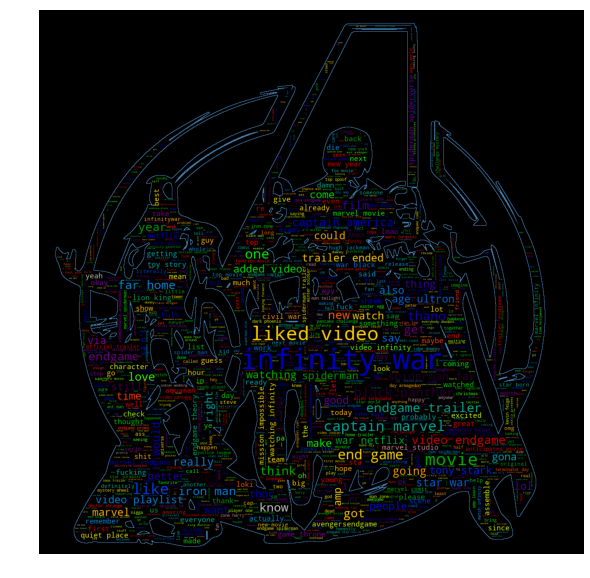

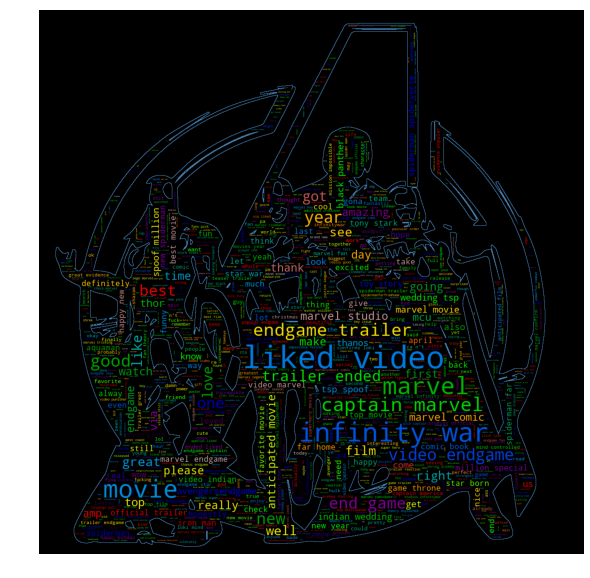

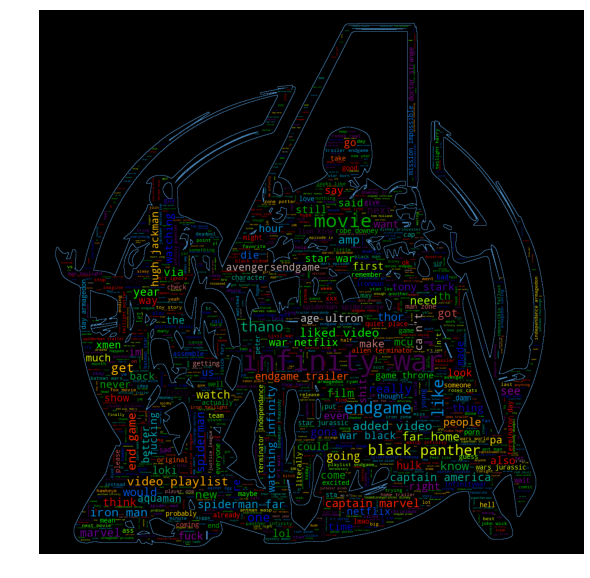

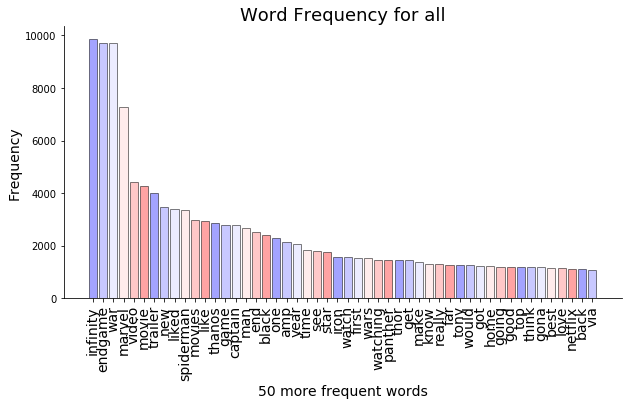

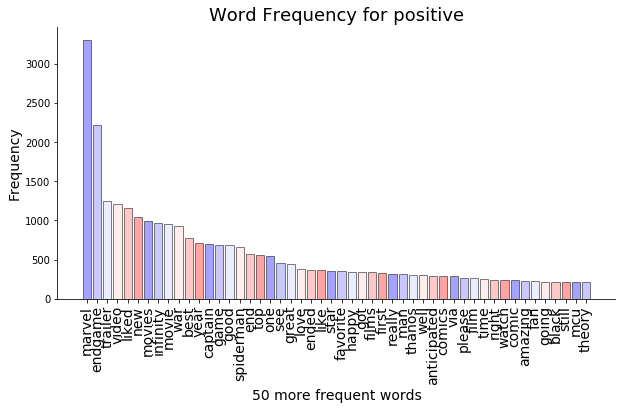

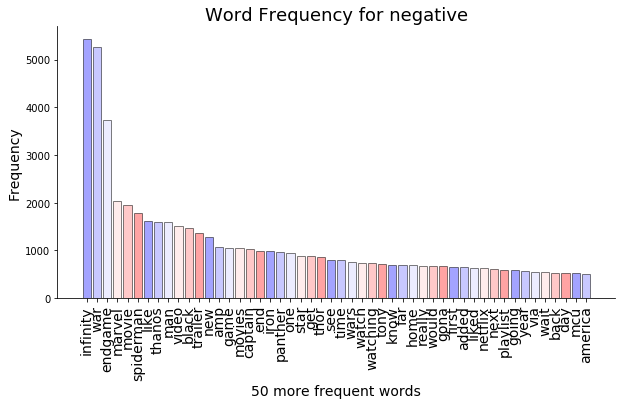

In [18]:
if __name__ == "__main__":    
    #First we draw a word cloud
    #For All tweets
    word_cloud(pd.Series([t for t in tweet_table.tweet]).str.cat(sep=' '))    
    #For positive tweets 
    word_cloud(pd.Series([t for t in tweet_table[tweet_table.sentiment == 'Positive'].tweet]).str.cat(sep=' '))   
    #For negative tweets
    word_cloud(pd.Series([t for t in tweet_table[tweet_table.sentiment == 'Negative'].tweet]).str.cat(sep=' '))
    
    
    #Graph with frequency words all, positive and negative tweets and get the frequency
    graph(tweet_table, 'all')
    graph(tweet_table[tweet_table['sentiment'] == 'Positive'], 'positive')
    graph(tweet_table[tweet_table['sentiment'] == 'Negative'], 'negative')

In [ ]:
if __name__ == "__main__":
    tweet_table['sentiment'] = tweet_table['sentiment'].apply(lambda x: 2 if x == 'Positive' else (0 if x == 'Negative' else 1))

In [ ]:
if __name__ == "__main__":
    X_train, X_test, y_train, y_test = splitting(tweet_table)
    X_train_mod = tokenization_tweets(X_train)
    model = train(X_train_mod, y_train)
    test(X_test, y_test, model)